---
# Creando una red convolucional con Pytorch
---

A continuación se realizará la implementación.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F #capas sin parametros

In [ ]:
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net,self).__init__()               #inicializando la clase padre
    
    self.num_channels = num_channels
    
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)
    
    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)
    
  def forward(self,x):
    #Empieza 3x64x64
    x = self.conv1(x) # num_channels x 64 x 64
    x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32
    x = self.conv2(x) # num_channels*2 x 32 x32
    x = F.relu(F.max_pool2d(x, 2)) #num_channels*2 x 16 x 16
    x = self.conv3(x) # num_channels*4 x16x16
    x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8
    
    #flatten
    x = x.view(-1, self.num_channels*4*8*8)
    
    #fc
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    
    #log_softmax
    
    x = F.log_softmax(x, dim=1)
    
    return x

* init, colocar parámetros
* forward, colocar todo lo demás

In [ ]:
from google.colab import drive #importamos google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/dl-pytorch/datasets/"
!ls

/content/drive/My Drive/Colab Notebooks/dl-pytorch/datasets
64x64_SIGNS  64x64_SIGNS.zip


In [ ]:
#solo hacerlo 1 vez
#!unzip 64x64_SIGNS.zip #discomprimimos

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/dl-pytorch')

In [ ]:
from plot_helpers import imshow

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class SIGNSDataset(Dataset):
  def __init__(self, base_dir, split="train", transform=None):
    path = os.path.join(base_dir, "{}_signs".format(split))
    files = os.listdir(path)
    
    self.filenames = [os.path.join(path,f) for f in files if f.endswith(".jpg")]
    
    self.targets = [int(f[0]) for f in files]
    self.transform = transform
    
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self,idx):
    image = Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)
    return image, self.targets[idx]

In [ ]:
signs = SIGNSDataset('/content/drive/My Drive/Colab Notebooks/dl-pytorch/datasets/64x64_SIGNS', split="train")

In [ ]:
len(signs)

864

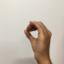

In [ ]:
signs[0][0]

---
# Preprocesamiento
---

In [ ]:
import torchvision.transforms as transforms

In [ ]:
trainset = SIGNSDataset('/content/drive/My Drive/Colab Notebooks/dl-pytorch/datasets/64x64_SIGNS', split="train", transform = transforms.ToTensor())

In [ ]:
dataloader = DataLoader(trainset, batch_size=32)  #cargador de datos, este dataloader es iterable

Considerando que el dataloader es iterable se procede a crear una cuadricula de imágenes (grid)

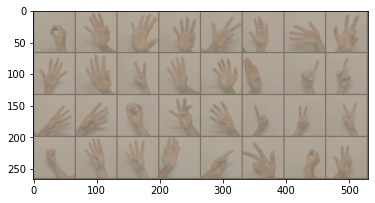

tensor([0, 5, 5, 5, 3, 5, 5, 3, 5, 5, 2, 4, 5, 4, 1, 1, 4, 4, 0, 4, 4, 1, 2, 2,
        0, 4, 4, 5, 1, 3, 0, 3])


In [ ]:
from torchvision.utils import make_grid

for inputs, targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break

Para poder entrenar la red hay que fijarse muy bien en el metodo de optimización, antes de entrenar la red hay que instanciar ciertas cosas:

  - Instanciar Net



In [ ]:
import torch.optim as optim

In [ ]:
device = torch.device('cuda')
device                            #verificando que sea cuda

device(type='cuda')

In [ ]:
print(torch.__version__)

1.7.1+cu101


In [ ]:
net = Net(32).to(device)                                             # Instanciado la red neuronal y llevandola a GPU

loss_fn = nn.NLLLoss()                                               # loss function --->funcion de perdida
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)     # optimizador , 1e-3= 0,001

La siguiente clase se encargará de hacer promedios en el tiempo, después de agregar datos:

In [ ]:
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0
    
  def update(self, val, size):
    self.S += val
    self.N += size
    
  def __call__(self):
    return self.S/float(self.N)         #permite entregar el promedio

### Loop de entrenamiento.

Hay que tenerse en cuenta que los epochs son diversos recorridos por los datos para poder hacer el backpropagation.

  -   _running_loss = RunningMetric()_ # para instanciar la métrica de perdida. (tasa de error de predicción de la red)
  -   _running_acc = RunningMetric()_ #Para instanciar la métrica de precisión. (porcentaje de predicciones correctas)

In [ ]:
num_epochs = 100   #100 pasadas por el dataset entero

In [ ]:
for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-'*10)
  
  running_loss = RunningMetric() # perdida
  running_acc = RunningMetric()  #precision
  
  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device)           # Llevando el inputs y el target a GPU
    optimizer.zero_grad()                                             # optimizando y reiniciando los gradientes a cero.
    
    outputs = net(inputs)                                             # Pasando las imágenes (inputs) por la red, generandose números.
    _, preds = torch.max(outputs,1)                                   # obtenemos la predicción que es el valor máximo de los outputs. 
    loss = loss_fn(outputs, targets)                                  # Calculando la pérdida (calculando los valores reales con los target)
    
    loss.backward()  #magias: gradientes calculados automaticamente
    optimizer.step() #magia2: actualiza las perillas o los parametros
    
    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size,
                       batch_size)
    running_acc.update(torch.sum(preds == targets).float(),
                       batch_size)
  print("Loss: {:.4f} Acc: {:.4f} ".format(running_loss(),
                                          running_acc()))

Epoch 1/100
----------
Loss: 1.7934 Acc: 0.1516 
Epoch 2/100
----------
Loss: 1.7924 Acc: 0.1435 
Epoch 3/100
----------
Loss: 1.7918 Acc: 0.1412 
Epoch 4/100
----------
Loss: 1.7913 Acc: 0.1551 
Epoch 5/100
----------
Loss: 1.7909 Acc: 0.1667 
Epoch 6/100
----------
Loss: 1.7906 Acc: 0.1701 
Epoch 7/100
----------
Loss: 1.7902 Acc: 0.2060 
Epoch 8/100
----------
Loss: 1.7899 Acc: 0.2512 
Epoch 9/100
----------
Loss: 1.7895 Acc: 0.1898 
Epoch 10/100
----------
Loss: 1.7891 Acc: 0.1748 
Epoch 11/100
----------
Loss: 1.7887 Acc: 0.1736 
Epoch 12/100
----------
Loss: 1.7883 Acc: 0.1725 
Epoch 13/100
----------
Loss: 1.7879 Acc: 0.1725 
Epoch 14/100
----------
Loss: 1.7874 Acc: 0.1725 
Epoch 15/100
----------
Loss: 1.7868 Acc: 0.1736 
Epoch 16/100
----------
Loss: 1.7861 Acc: 0.1736 
Epoch 17/100
----------
Loss: 1.7854 Acc: 0.1736 
Epoch 18/100
----------
Loss: 1.7846 Acc: 0.1736 
Epoch 19/100
----------
Loss: 1.7836 Acc: 0.1748 
Epoch 20/100
----------
Loss: 1.7824 Acc: 0.1829 
Epoch 21/

Si obtienen en google colab, el CUDA error(100) quizás olvidar activar en el entorno de ejecución de tipo GPU.

Para esto, vayan a Runtime (Entorno de Ejecución) -> change Runtime Type (cambiar entorno de ejecución) -> Finalmente escoger Hardware GPU.

# Evaluando la performance de la red neuronal

### Implementando la regularizacion de las redes neuronales

In [ ]:
import torchvision.transforms as transforms

A continuacion se realizará un metodo de regularizacion llamado **Data augmenation** elcual podra girar, cortar o zoomear las imagenes y de esta maenra crear un mayor dataset.

In [ ]:
transform = transforms.Compose(     #Compose permite hacer pipeline de transformacion
  [transforms.RandomHorizontalFlip(), #data augmentation  ---->esta funcion gira imágenes
   transforms.ToTensor(),
   transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) #hace normalizacion en input (media,med), (sd,sd, )
  ]
)

In [ ]:
trainset = SIGNSDataset('/content/drive/My Drive/Colab Notebooks/dl-pytorch/datasets/64x64_SIGNS', split="train", transform = transform)
trainloader = DataLoader(trainset,batch_size=32)

In [ ]:
valset = SIGNSDataset('/content/drive/My Drive/Colab Notebooks/dl-pytorch/datasets/64x64_SIGNS', split="val", transform = transform)
valloader = DataLoader(valset,batch_size=32)

In [ ]:
testset = SIGNSDataset('/content/drive/My Drive/Colab Notebooks/dl-pytorch/datasets/64x64_SIGNS', split="test", transform = transform)
testloader = DataLoader(testset,batch_size=32)

In [ ]:
dataloaders = {'train':trainloader,
              'val':valloader,
              'test':testloader}

Se procede a copiar la estructura de la red, pero se le agrega batchnorm y dropout

In [ ]:
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net,self).__init__()
    
    self.num_channels = num_channels
    
    #adicionando batchnorm (self.bn1 , self.bn2 , self.bn3 )
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding = 1)
    self.bn1 = nn.BatchNorm2d(self.num_channels)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.bn2 = nn.BatchNorm2d(self.num_channels*2)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)
    self.bn3 = nn.BatchNorm2d(self.num_channels*4)
    
    # self.fcbn1:batchnorm full conected
    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fcbn1 = nn.BatchNorm1d(self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)
    
    #colocando las batch normalizaciones , toca antes de las convoluciones
  def forward(self,x):
      #Empieza 3x64x64
      x = self.bn1(self.conv1(x)) # num_channels x 64 x 64
      x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32
      x = self.bn2(self.conv2(x)) # num_channels*2 x 32 x32
      x = F.relu(F.max_pool2d(x, 2)) #num_channels*2 x 16 x 16
      x = self.bn3(self.conv3(x)) # num_channels*4 x16x16
      x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8

      #flatten
      x = x.view(-1, self.num_channels*4*8*8)

      #fc---->full conected
      x = F.relu(self.fcbn1(self.fc1(x)))
      x = F.dropout(x, p = 0.8, training=True)    #colocando dropout
      x = self.fc2(x)

      #log_softmax

      x = F.log_softmax(x, dim=1)

      return x

# Optimizacion de hiperparametros

In [ ]:
def train_and_evaluate(model, optimizer, loss_fn, dataloaders, device, num_epochs = 10, lr = 0.001): #pasando los nuevos dataloaders, demas cosas
  
  for g in optimizer.param_groups:  #permite modificar el lr=0.001 al momento de usar el optimizer
    g['lr'] = lr
    
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-'*10)
    
    #esta linea es importante porque permite clasificar y entrenar dependiendo si se quiere validar o entrenar
    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = RunningMetric() # perdida
      running_acc = RunningMetric() #precision

      for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):   #unicamente en entrenamiento
          outputs = net(inputs)
          _, preds = torch.max(outputs,1)
          loss = loss_fn(outputs, targets)
          if phase == 'train':                             #unicamente en test
            loss.backward() #magias: gradientes calculados automaticamente
            optimizer.step() #magia2: actualiza las perillas o los parametros

        batch_size = inputs.size()[0]
        running_loss.update(loss.item()*batch_size,
                           batch_size)
        running_acc.update(torch.sum(preds == targets).float(),
                           batch_size)
      print("Loss: {:.4f} Acc: {:.4f} ".format(running_loss(),
                                              running_acc()))
  return model

In [ ]:
import random

lrs = [10**(-random.randint(3,7)) for _ in range(3)]

In [ ]:
for lr in lrs:
  train_and_evaluate(net,optimizer,loss_fn,dataloaders, device, 10, lr)

Epoch 1/10
----------
Loss: 0.1645 Acc: 0.9421 
Loss: 0.0670 Acc: 0.9826 
Epoch 2/10
----------
Loss: 0.0849 Acc: 0.9676 
Loss: 0.0568 Acc: 0.9873 
Epoch 3/10
----------
Loss: 0.0699 Acc: 0.9826 
Loss: 0.0512 Acc: 0.9919 
Epoch 4/10
----------
Loss: 0.0579 Acc: 0.9873 
Loss: 0.0478 Acc: 0.9931 
Epoch 5/10
----------
Loss: 0.0550 Acc: 0.9896 
Loss: 0.0461 Acc: 0.9942 
Epoch 6/10
----------
Loss: 0.0532 Acc: 0.9884 
Loss: 0.0450 Acc: 0.9954 
Epoch 7/10
----------
Loss: 0.0516 Acc: 0.9907 
Loss: 0.0439 Acc: 0.9954 
Epoch 8/10
----------
Loss: 0.0500 Acc: 0.9907 
Loss: 0.0429 Acc: 0.9954 
Epoch 9/10
----------
Loss: 0.0489 Acc: 0.9907 
Loss: 0.0420 Acc: 0.9954 
Epoch 10/10
----------
Loss: 0.0476 Acc: 0.9919 
Loss: 0.0412 Acc: 0.9954 
Epoch 1/10
----------
Loss: 0.0412 Acc: 0.9954 
Loss: 0.0412 Acc: 0.9954 
Epoch 2/10
----------
Loss: 0.0412 Acc: 0.9954 
Loss: 0.0411 Acc: 0.9954 
Epoch 3/10
----------
Loss: 0.0411 Acc: 0.9954 
Loss: 0.0411 Acc: 0.9954 
Epoch 4/10
----------
Loss: 0.0411 Ac

Luego despues de lo anterior se podria seleccionar el mejor lr.

# Transfer Learning

Lo que se puede realizar es cambio de estilo, conociendo dos imágenes crear una completamente nueva producto de estas dos.

In [ ]:
from torchvision import models
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
for param in vgg.parameters():
  param.requires_grad = False

In [ ]:
last_sequential_layer = list(vgg.children())[-1]
*list_of_layers, last_layer = list(last_sequential_layer.children())
in_features = last_layer.in_features

vgg.fc = nn.Linear(in_features,6)
vgg.fc.requires_grad = True
vgg.classifier = nn.Sequential(*(list_of_layers+[vgg.fc]))

In [ ]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)

In [ ]:
trainset = SIGNSDataset('/content/drive/My Drive/Colab Notebooks/dl-pytorch/datasets/64x64_SIGNS', split="train", transform = transform)
trainloader = DataLoader(trainset,batch_size=32)

valset = SIGNSDataset('/content/drive/My Drive/Colab Notebooks/dl-pytorch/datasets/64x64_SIGNS', split="val", transform = transform)
valloader = DataLoader(valset,batch_size=32)

testset = SIGNSDataset('/content/drive/My Drive/Colab Notebooks/dl-pytorch/datasets/64x64_SIGNS', split="test", transform = transform)
testloader = DataLoader(testset,batch_size=32)

dataloaders = {'train':trainloader,
              'val':valloader,
              'test':testloader}

In [ ]:
inputs, tartgets = next(iter(dataloaders["train"]))

In [ ]:
vgg = vgg.to(device)
_, preds = torch.max(vgg(inputs.to(device)),1)

In [ ]:
vgg(inputs.to(device)).size()

torch.Size([32, 6])

In [ ]:
train_and_evaluate(vgg, optimizer, loss_fn, dataloaders, device, num_epochs = 100)

Epoch 1/100
----------
Loss: 0.0615 Acc: 0.9884 
Loss: 0.1821 Acc: 0.9248 
Epoch 2/100
----------
Loss: 0.0724 Acc: 0.9826 
Loss: 0.1920 Acc: 0.9329 
Epoch 3/100
----------
Loss: 0.0648 Acc: 0.9873 
Loss: 0.1275 Acc: 0.9583 
Epoch 4/100
----------
Loss: 0.0645 Acc: 0.9884 
Loss: 0.2318 Acc: 0.9167 
Epoch 5/100
----------
Loss: 0.0668 Acc: 0.9873 
Loss: 0.1777 Acc: 0.9375 
Epoch 6/100
----------
Loss: 0.0680 Acc: 0.9873 
Loss: 0.1376 Acc: 0.9444 
Epoch 7/100
----------
Loss: 0.0692 Acc: 0.9850 
Loss: 0.1762 Acc: 0.9329 
Epoch 8/100
----------
Loss: 0.0718 Acc: 0.9826 
Loss: 0.1339 Acc: 0.9502 
Epoch 9/100
----------
Loss: 0.0721 Acc: 0.9826 
Loss: 0.1194 Acc: 0.9560 
Epoch 10/100
----------
Loss: 0.0747 Acc: 0.9815 
Loss: 0.1222 Acc: 0.9525 
Epoch 11/100
----------
Loss: 0.0706 Acc: 0.9838 
Loss: 0.1222 Acc: 0.9537 
Epoch 12/100
----------
Loss: 0.0649 Acc: 0.9850 
Loss: 0.1367 Acc: 0.9502 
Epoch 13/100
----------
Loss: 0.0637 Acc: 0.9907 
Loss: 0.1806 Acc: 0.9340 
Epoch 14/100
--------

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1